# Nim Malware Analysis

From the malware analysis perspective, Nim has some fascinating characteristics. Let's focus on one for this talk (I am happy to talk about this for hours if you want!)

## All Nim Windows Binaries Dynamically Resolve Their APIs
Let's perform an experiement.

In the `samples` directory, I have a number of malware samples. We will examine a program written in Nim and a program written in a different language and compare them.

The first sample is a simple, four line C++ program that calls the ShellExecute API. Let's examine the code:

In [27]:
!cat ../samples/src/shellexec/cpp_shellexec/cpp_shellexec/cpp_shellexec.cpp

#include <iostream>
#include <windows.h>
#include <ShellApi.h>

int main()
{
    ShellExecute(0, L"open", L"notepad", L"", NULL, SW_SHOW);
}



The code is incredibly simple, but something interesting happens when this code is compiled. The compiler identifies the ShellExecute API in the code and links the required DLL and API into the binary's Import Address Table (IAT). The IAT acts as a phone book for the API calls that a binary uses during execution.

When this C++ program is compiled and examined, its IAT includes the ShellExec API call:

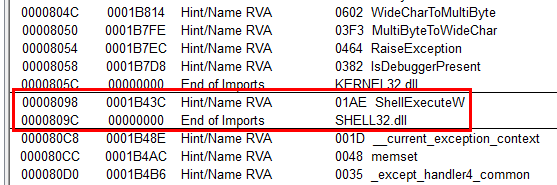

This can inform malware analysts very quickly about the existence of malicious code in a binary.

In the `src` directory of this notebook, I've included a copy of `MalAPIReader`, a collaboration between myself, [@SquiblydooBlog](https://twitter.com/SquiblydooBlog) and [mrd0x](https://twitter.com/mrd0x). This program is a Python script that pulls the Import Address Table out from a portable executable and checks each Windows API call against https://malapi.io. This helps to find API calls that are commonly used by malware.

We will use `MalAPIReader` with two different PEs in this directory and compare the difference. First, let's examine this C++ program.

---

In [28]:
!python3 ../src/MalAPIReader/MalAPIReader.py --pe ../samples/shellexec/cpp_shellexec.exe

---------------MalAPIReader.py---------------
Hit: ShellExecuteA
Hit: TerminateProcess
Hit: GetCurrentProcess
Hit: GetProcAddress
Hit: GetProcessHeap
Hit: HeapAlloc
Hit: GetModuleHandleA
Hit: GetCurrentThreadId
Hit: GetSystemTimeAsFileTime
Hit: GetCurrentProcessId
Hit: QueryPerformanceCounter
Hit: IsDebuggerPresent
Sample: ../samples/shellexec/cpp_shellexec.exe

ShellExecuteA
    \\---> ShellExecuteA is used to perform an operation on a specified file.
TerminateProcess
    \\---> TerminateProcess is used to terminate a process.
GetCurrentProcess
    \\---> GetCurrentProcess is used to retrieve a handle for the current process.
GetProcAddress
    \\---> GetProcAddress is used to get the memory address of a function in a DLL. This is often used by malware for obfuscation and evasion purposes to avoid having to call the function directly.
GetProcessHeap
    \\---> GetProcessHeap is used to retrieve a handle to the default heap of the calling process.
HeapAlloc
    \\---> HeapAlloc is used

---
The MalAPIReader script should have identified `ShellExecute`, a Win API that is commonly used to interact with files. We can then examine this API call and its parameters to identify what the API call is doing:

In [26]:
import pefile

for entry in pe.DIRECTORY_ENTRY_IMPORT:
    if "SHELL32.dll" in str(entry.dll):
        for imp in entry.imports:
            print('\t', hex(imp.address), imp.name)

	 0x41b098 b'ShellExecuteW'


If we open this PE in something like Cutter, we can locate the function by cross-referencing the ShellExecW string:

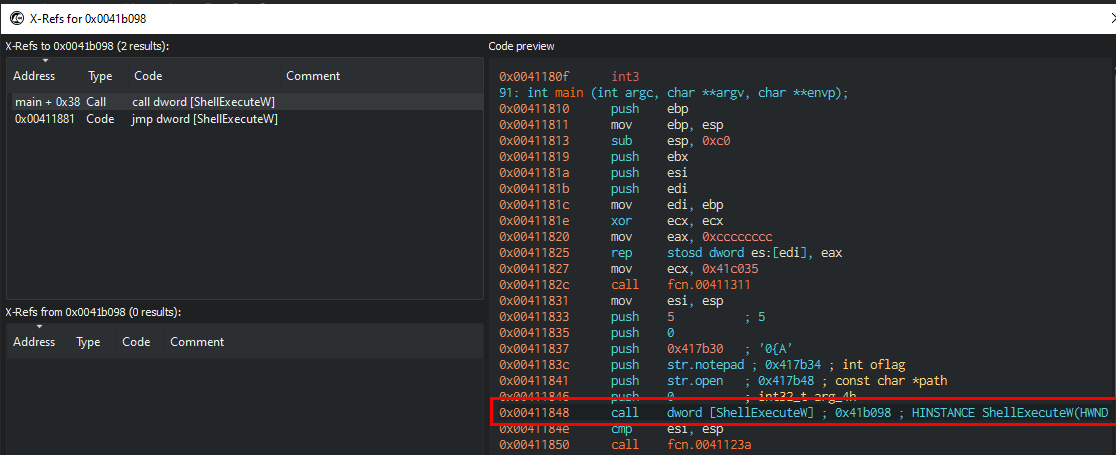

... and we see the API call. We can then examine its parameters.

This call simply opens notepad.exe:

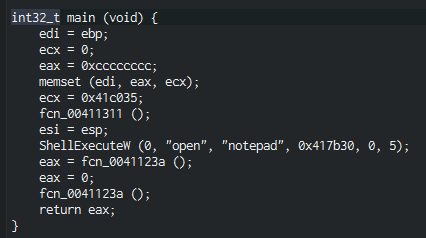

---
Now, let's do the same thing for a program that does the exact same thing, but is written in Nim.

In [39]:
!cat ../samples/src/shellexec/nim_shellexec/shellexec.nim

#[ Simple ShellExecute API call

    Compile:
        nim c -d:mingw --cpu:i386 shellexecute.nim

]#

import winim

let shellexec = ShellExecute(
    0,
    "open",
    "notepad",
    "",
    NULL,
    SW_SHOW
)

discard(shellexec)

The Nim POC makes use of the `winim` library, which allows for direct access to Win API calls.

Let's run MalAPIReader against this sample:

In [41]:
!python3 ../src/MalAPIReader/MalAPIReader.py --pe ../samples/shellexec/nim_shellexec.exe

---------------MalAPIReader.py---------------
Hit: GetCurrentProcess
Hit: GetCurrentProcessId
Hit: GetCurrentThreadId
Hit: GetProcAddress
Hit: GetSystemTimeAsFileTime
Hit: GetTickCount
Hit: QueryPerformanceCounter
Hit: Sleep
Hit: TerminateProcess
Hit: VirtualAlloc
Hit: VirtualProtect
Sample: ../samples/shellexec/nim_shellexec.exe

GetCurrentProcess
    \\---> GetCurrentProcess is used to retrieve a handle for the current process.
GetCurrentProcessId
    \\---> GetCurrentProcessId is used to retrieve the process identifier of the calling process.
GetCurrentThreadId
    \\---> GetCurrentThreadId is used to retrieve the thread identifier of the calling thread.
GetProcAddress
    \\---> GetProcAddress is used to get the memory address of a function in a DLL. This is often used by malware for obfuscation and evasion purposes to avoid having to call the function directly.
GetSystemTimeAsFileTime
    \\---> Retrieves the current system date and time. The information is in Coordinated Universa

---
We do get some hits for potentially malicious API calls, and we even get a few that were not in the C++ example, but there is one noteable omission.

**ShellExecuteA** is not in the output.

This is because when Nim seeks to link API calls within a Windows binary, it does not add them to the IAT. Instead, it utilizes two API calls, **LoadLibraryA** and **GetProcAddress**, to resolve these API calls dynamically when the binary is executed.

There are interesting OPSEC implications for this method of API resolution. Consider that you could fill a Nim binary with many different API calls that are normally flagged as malicious and static detection mechanisms will not identify them (that does not mean they are undetectable, however!)

The Nim binary's IAT:

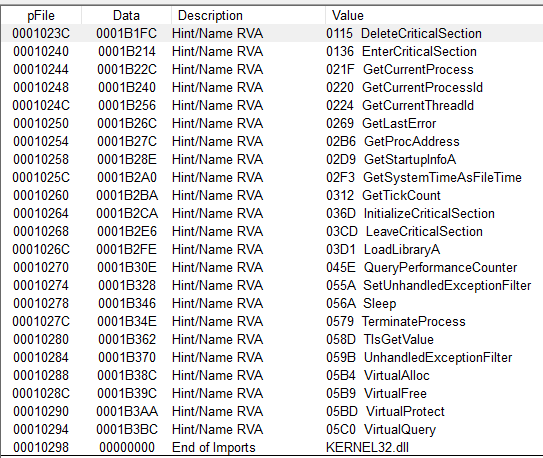

These API calls are common to most Nim binaries and always include GetProcAddress and LoadLibrary.

---
## [Previous: A Brief History of Nim](HistoryOfNim.ipynb) ||--0--|| [Next: Nim's Offensive Applications](OffensiveNim.ipynb)

This is a picture from the VirusTotal page for SikoMode, one of the PMAT challenge binaries written in Nim.

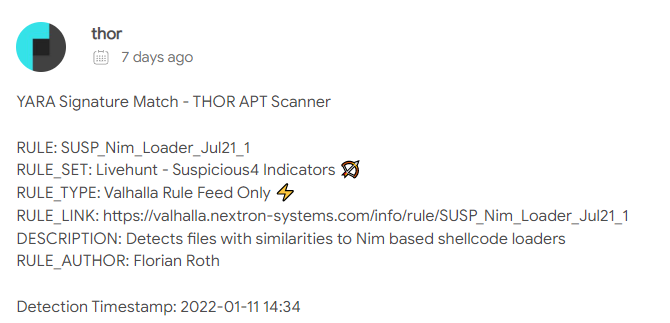